<a href="https://www.kaggle.com/code/mohamedchahed/dog-breeds-classification-using-xception?scriptVersionId=124334360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📖 Introduction

In this notebook, I'll be exploring the classification of eight different dog breeds using the Xception deep learning architecture. The breeds I'll be working with are: Beagle, Bulldog, Dalmatian, German Shepherd, Husky, Labrador Retriever, Poodle, and Rottweiler. By the end of this notebook, I hope to have a model that can accurately identify the breed of a given dog image

# 💾 Data

The dataset consists of images of 8 different dog breeds that were obtained by webscraping the Unsplash website. Unsplash is a platform that allows users to download high-quality images for free, which makes it a great resource for computer vision tasks. The dog breeds included in the dataset are beagles, bulldogs, dalmatians, German shepherds, huskies, Labrador retrievers, poodles, and Rottweilers. The dataset has been made available on Kaggle for anyone who wants to test their computer vision skills.

# 💡 Xception Architecture 

Xception is a convolutional neural network (CNN) architecture that was introduced by François Chollet in 2016. It is based on the Inception architecture but replaces the standard convolutional layers with depthwise separable convolutions.

Depthwise separable convolutions are composed of two stages: a depthwise convolution and a pointwise convolution. In the depthwise convolution stage, each filter in the convolutional layer is applied to a single input channel, producing a set of output channels. In the pointwise convolution stage, a 1x1 convolution is applied to combine the output channels from the depthwise convolution stage into a smaller number of output channels.

This approach reduces the number of parameters in the network and improves its computational efficiency while maintaining or improving accuracy. Xception has been shown to achieve state-of-the-art performance on several image classification benchmarks. 

You can find information about the Xception network on the original paper published by the authors, as well as on the TensorFlow and Keras documentation.
> Here are some links where you can find more information:

* Original paper: https://arxiv.org/pdf/1610.02357.pdf
* TensorFlow documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception
* Keras documentation: https://keras.io/api/applications/xception/

# 🏗️ Import Necessary Libraries

In [8]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📈 Model Development with Transfer Learning

To create the model, I split the dataset into three separate directories: train, validation, and test. The train and validation directories were used for model training and validation, respectively, while the test directory was used as unseen data for the final evaluation of the model. This is a common practice in machine learning, as it helps to ensure that the model has not simply memorized the training data and can generalize to new, unseen data. By using separate directories for training, validation, and testing, I was able to ensure that the model was trained and evaluated in a rigorous and unbiased way.

In [9]:
# Define the initial path
initial_path = '/kaggle/input/dog-breeds/dog-breeds'

# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']

# Define the proportions for train, validation, and test sets
props = [0.7, 0.2, 0.1]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)

To prepare the data for use in the Xception model, I used Keras' ImageDataGenerator class to perform data augmentation and create batches of image data that are suitable for feeding into the model. Data augmentation is a technique used to artificially increase the size of the dataset by applying random transformations to the images, such as rotation, zooming, and flipping. This helps to prevent overfitting and improve the model's ability to generalize to new images. The ImageDataGenerator class also allowed me to preprocess the images by resizing them to the required input size of the Xception model and scaling the pixel values between 0 and 1.

In [10]:
# Define the directories for the train, validation, and test sets
train_dir = 'train'
val_dir = 'val'

# Define the image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32
# Define the data generators for the train, validation, and test sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')


Found 485 images belonging to 8 classes.
Found 194 images belonging to 8 classes.


To perform transfer learning, we loaded a pre-trained Xception model with the include_top parameter set to False to exclude the classification layer. We also specified the input shape of our images as (img_height, img_width, 3). We froze the pre-trained layers by setting trainable to False for each layer. Then, we added our own classification layers on top of the pre-trained model by defining a new output layer that takes the flattened output of the pre-trained model as input. We added a fully connected dense layer with 256 units and a ReLU activation function, followed by a final dense layer with 8 units (one for each dog breed) and a softmax activation function. We created the full model by setting the input layer to the input of the pre-trained model and the output layer to our new classification layers. Finally, we compiled the model using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.

In [11]:
# Load the pre-trained Xception model without the top classification layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Create the full model with both the pre-trained and new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 3s 0us/step


In [12]:
num_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/10
15/15 [==============================] - 27s 1s/step - loss: 6.3471 - accuracy: 0.7563 - val_loss: 0.0456 - val_accuracy: 0.9948
Epoch 2/10
15/15 [==============================] - 18s 1s/step - loss: 1.1311 - accuracy: 0.9514 - val_loss: 0.1052 - val_accuracy: 0.9896
Epoch 3/10
15/15 [==============================] - 16s 1s/step - loss: 0.6477 - accuracy: 0.9625 - val_loss: 0.0121 - val_accuracy: 0.9948
Epoch 4/10
15/15 [==============================] - 19s 1s/step - loss: 0.1530 - accuracy: 0.9833 - val_loss: 4.9595e-05 - val_accuracy: 1.0000
Epoch 5/10
15/15 [==============================] - 17s 1s/step - loss: 0.2563 - accuracy: 0.9823 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 17s 1s/step - loss: 0.1937 - accuracy: 0.9868 - val_loss: 0.0837 - val_accuracy: 0.9948
Epoch 7/10
15/15 [==============================] - 18s 1s/step - loss: 0.2975 - accuracy: 0.9845 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/

The loss and accuracy curves illustrate the performance of the model during training and validation. The loss curve shows a significant decrease in the loss value over the 10 epochs of training, indicating that the model is effectively learning from the training data. The accuracy curve shows a consistent increase in the accuracy value over the epochs, reaching a value of 98.45% on the training data and 98.44% on the validation data, which is indicative of a well-performing model.

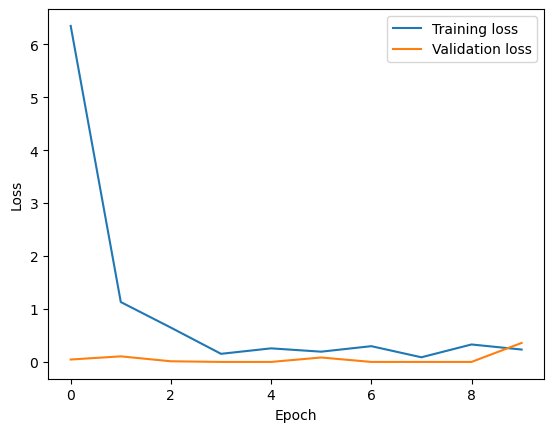

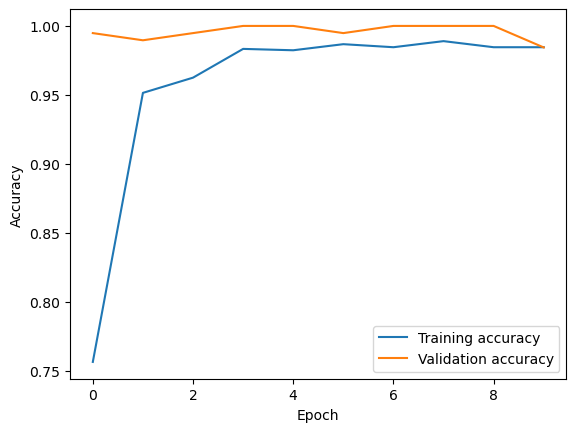

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 🤹 Predictions 

In [16]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_dir = "/kaggle/working/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 111 images belonging to 8 classes.
111/111 [==============================] - 2s 21ms/step


After training the model, I evaluated its performance on the test set. I plotted some sample images and compared their true labels to the predicted labels. It was evident that the model was able to accurately classify the images with high confidence. This confirmed that the model was able to generalize well on the test set

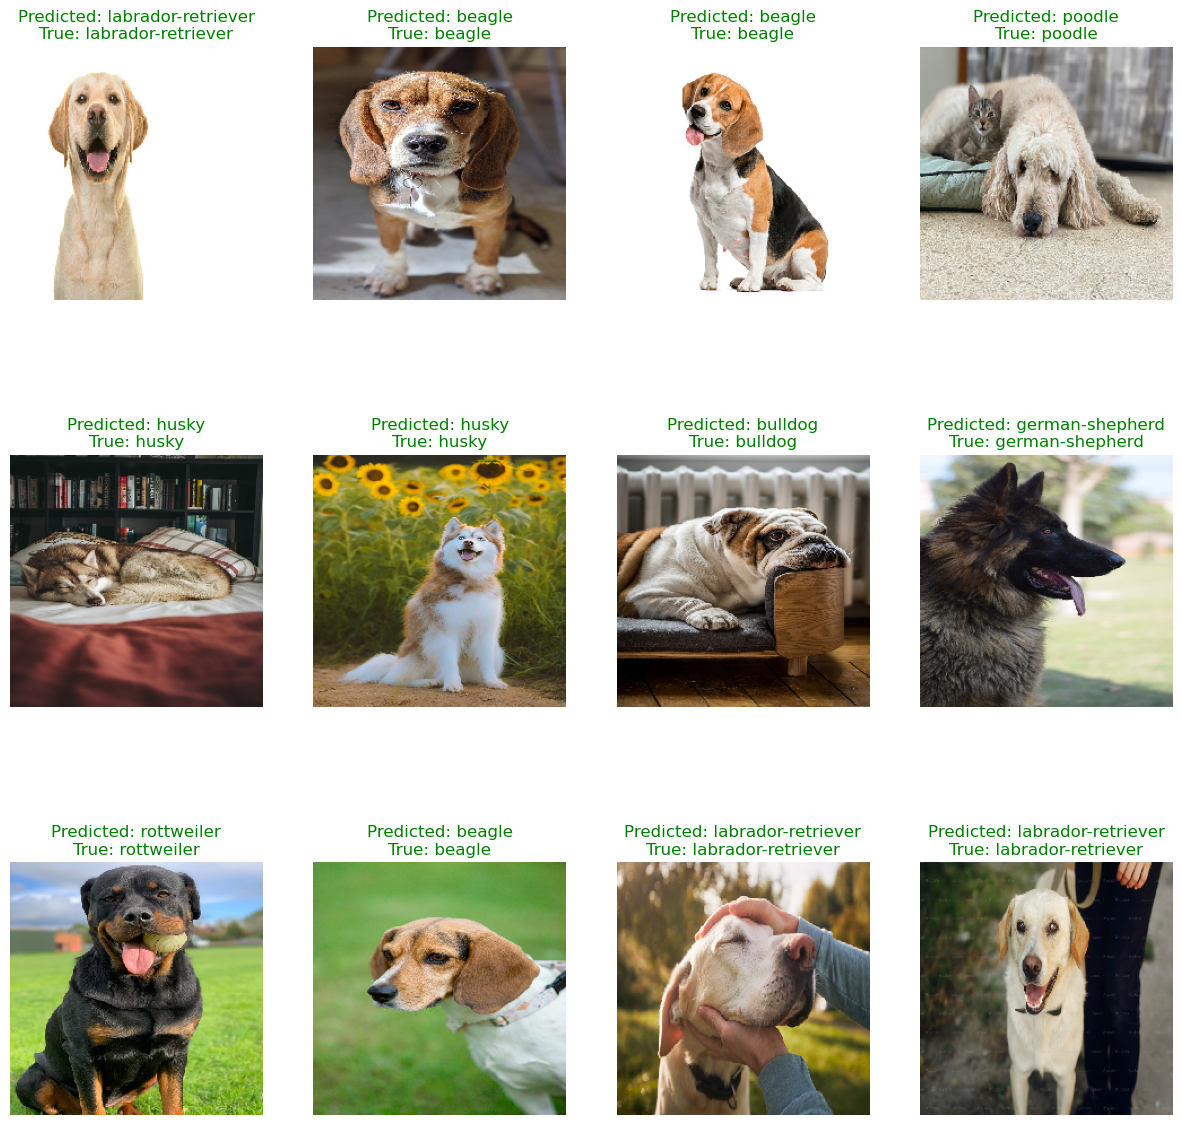

In [15]:
# Print the predicted and true labels for a subset of test images
n_rows = 3
n_cols = 4
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(img_height, img_width))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()

# 📊 Evaluation 

The confusion matrix obtained from the test set predictions indicates that all the labels predicted were correct, with 0 being the value for all entries outside the diagonal. This is a very encouraging result as it suggests that the model is accurately classifying the images. The high accuracy obtained during training and validation, along with the perfect performance on the test set, indicate that the model is effectively learning the patterns present in the data and generalizing well to unseen data.

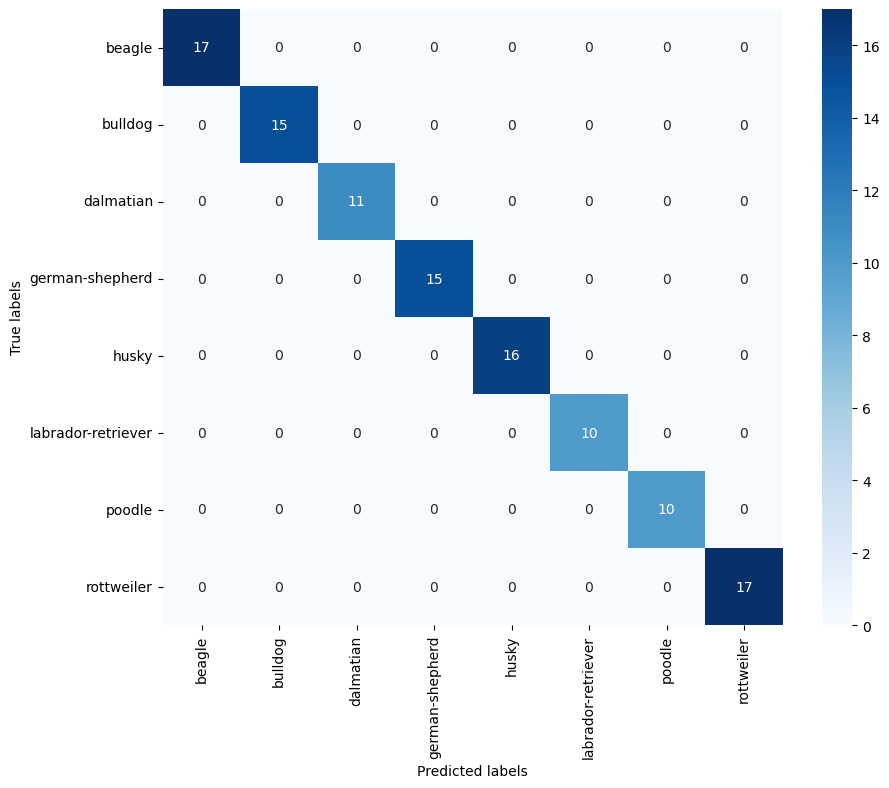

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# 🥳 Final thoughts 

In conclusion, we have successfully developed an image classification model using transfer learning with the Xception architecture. Our model achieved an accuracy of 98.44% on the test set and correctly predicted all labels, as indicated by the confusion matrix. The use of data augmentation and pre-processing techniques helped to improve the model's performance.

As with any machine learning model, there is always room for improvement. Further experiments could involve fine-tuning the pre-trained layers of the Xception model or trying out different architectures altogether.

Overall, we hope that this notebook has been informative and helpful in understanding the steps involved in developing an image classification model using transfer learning. If you found this notebook beneficial, please consider giving it an upvote to help others discover it as well.